In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.fft as fft
from numpy.fft import fft2, ifft2, fftshift
import time

##
## Masked NCC

In [47]:
def masked_ncc_fft_precomputed(search_image, fft_I, fft_I2, template_data):
    fft_TM = template_data["fft_TM"]
    fft_M = template_data["fft_M"]
    sum_TM = template_data["sum_TM"]
    sum_TM2 = template_data["sum_TM2"]
    h, w = template_data["shape"]
    H, W = search_image.shape

    '''
    print("mask min/max:", np.min(template_data["mask"]), np.max(template_data["mask"]))
    print("template min/max:", np.min(template_data["template"]), np.max(template_data["template"]))
    '''

    num = ifft2(fft_I * np.conj(fft_TM)).real
    sum_I = ifft2(fft_I * np.conj(fft_M)).real
    sum_I2 = ifft2(fft_I2 * np.conj(fft_M)).real
    sum_M = ifft2(fft_M * np.conj(fft_M)).real

    # Avoid division by very small values in sum_M to stabilize variance calculations
    safe_sum_M = np.maximum(sum_M, 1e-4)

    val1 = sum_TM2 - (sum_TM ** 2) / safe_sum_M
    val2 = sum_I2 - (sum_I ** 2) / safe_sum_M

    '''
    print("val1 min/max before clamp:", np.min(val1), np.max(val1))
    print("val2 min/max before clamp:", np.min(val2), np.max(val2))
    print("Any val1 < 0 before clamp:", np.any(val1 < 0))
    print("Any val2 < 0 before clamp:", np.any(val2 < 0))
    '''

    val1 = np.maximum(val1, 0)
    val2 = np.maximum(val2, 0)

    denom = np.sqrt(val1 * val2 + 1e-8)

    with np.errstate(divide='ignore', invalid='ignore'):
        ncc_map = (num - (sum_I * sum_TM / safe_sum_M)) / denom
        ncc_map[sum_M < 1] = 0  # invalidate regions with very low mask support

    valid_h = H - h + 1
    valid_w = W - w + 1
    ncc_valid = ncc_map[:valid_h, :valid_w]

    _, max_val, _, max_loc = cv2.minMaxLoc(ncc_valid)

    '''
    print("denom min/max:", denom.min(), denom.max())
    print("num min/max:", num.min(), num.max())
    print("sum_M min/max:", sum_M.min(), sum_M.max())
    print("sum_I min/max:", sum_I.min(), sum_I.max())
    print("sum_I2 min/max:", sum_I2.min(), sum_I2.max())

    input("Press Enter to continue...")
    '''

    return ncc_valid, max_val, max_loc


##
## Template Matching + Bank

In [40]:
def get_patch(frame_gray, template_coords, padding=10):
    x, y, w, h = template_coords
    x_start = max(0, x - padding)
    y_start = max(0, y - padding)
    x_end = min(frame_gray.shape[1], x + w + padding)
    y_end = min(frame_gray.shape[0], y + h + padding)

    patch = frame_gray[y_start:y_end, x_start:x_end]
    patch_loc = (x_start, y_start)  # top-left of patch

    return patch, patch_loc

def display_patch(patch, frame_idx, padding):
    plt.figure(figsize=(4, 4))
    plt.imshow(patch, cmap='gray')
    plt.title(f"Patch (Frame {frame_idx}, Padding {padding})")
    plt.axis('off')
    plt.show()

def find_best_match(search_patch):
    best_score = -1
    best_box = None
    boxes = []
    scores = []

    # Get full padded shape (should be consistent)
    full_shape = template_bank[0]['fft_TM'].shape  # e.g. (1080, 1920)
    
    # Pad search_patch to full_shape
    padded_search = np.zeros(full_shape, dtype=np.float32)
    h, w = search_patch.shape
    padded_search[:h, :w] = search_patch.astype(np.float32)

    fft_I = fft2(padded_search)
    fft_I2 = fft2(padded_search ** 2)

    for template_data in template_bank:
        th, tw = template_data["shape"]

        if h < th or w < tw:
            continue

        ncc_map, score, loc = masked_ncc_fft_precomputed(
            padded_search, fft_I, fft_I2, template_data
        )

        if score > best_score:
            best_score = score
            best_box = (*loc, tw, th)

        boxes.append((*loc, tw, th))
        scores.append(score)

    if best_box is None:
        best_box = (0, 0, 0, 0)

    return boxes, scores, best_score, best_box


def update_template_from_box(frame_gray, box):
    x, y, w, h = box
    new_template = frame_gray[y:y+h, x:x+w]
    _, new_mask = cv2.threshold(new_template, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return new_template, new_mask

def add_to_template_bank(template, mask, image_shape):
    h, w = template.shape
    TM = template * mask

    TM_padded = np.zeros(image_shape, dtype=np.float32)
    M_padded = np.zeros(image_shape, dtype=np.float32)
    TM_padded[:h, :w] = TM
    M_padded[:h, :w] = mask

    fft_TM = fft2(TM_padded)
    fft_M = fft2(M_padded)
    sum_TM = np.sum(TM)
    sum_TM2 = np.sum(TM ** 2)

    return {
        "template": template.astype(np.float32),
        "mask": mask.astype(np.float32),
        "fft_TM": fft_TM,
        "fft_M": fft_M,
        "sum_TM": sum_TM,
        "sum_TM2": sum_TM2,
        "shape": (h, w)
    }

def apply_nms(boxes, scores, threshold, nms_thresh):
    if not boxes:
        return []

    indices = cv2.dnn.NMSBoxes(boxes, scores, threshold, nms_thresh)
    if len(indices) == 0:
        return []

    # Flatten indices to list of integers
    return [i[0] if isinstance(i, (list, np.ndarray)) else i for i in indices]

#================================================#
#======= FOR TEMPLATE BANK VISUALIZATION ========#
#================================================#

def get_template_index(template, template_bank):
    for i, (t, _) in enumerate(template_bank):
        if np.array_equal(t, template):
            return i
    return None

def visualize_template_bank(template_bank, current_index=None, max_per_row=5, figsize=(15, 5), cmap='gray'):
    n = len(template_bank)
    if n == 0:
        print("⚠️ Template bank is empty.")
        return

    cols = min(n, max_per_row)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, (template, mask) in enumerate(template_bank):
        ax = plt.subplot(rows, cols, i + 1)
        masked = cv2.bitwise_and(template, template, mask=mask)
        overlay = np.stack([masked]*3, axis=-1)
        overlay[mask == 0] = [255, 0, 0]  # red for masked out
        ax.imshow(overlay)
        title = f"Template {i}"
        if i == current_index:
            title += " (Current)"
            ax.set_title(title, color='red')
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)
        else:
            ax.set_title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


##
## Utility Functions

In [41]:
def read_video_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Cannot read video.")
        cap.release()
        return None, None, None
    return cap, frame, ret

def load_template(initial_template_path, frame_gray):
    template = cv2.imread(initial_template_path, cv2.IMREAD_GRAYSCALE)
    if template is None:
        print("Template image not found or failed to load.")
        return None

    coords = cv2.findNonZero(template)
    if coords is None:
        print("No non-zero pixels in template.")
        return None

    x, y, w, h = cv2.boundingRect(coords)
    cropped_template = frame_gray[y:y+h, x:x+w]
    return cropped_template, (x, y, w, h)

def setup_video_writer(output_path, frame_shape, fps):
    frame_h, frame_w = frame_shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))
    print(f"💾 Output video will be saved to: {output_path}")
    return out



##
## Main Tracking Function

In [42]:
def draw_tracking_box(frame, box):
    x, y, w, h = box
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)

def display_frame(frame, frame_idx):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()

def template_difference(template1, template2, threshold=0.2):
    if template1.shape != template2.shape:
        return True
    diff = np.mean((template1.astype(np.float32) - template2.astype(np.float32)) ** 2)
    norm = np.mean(template1.astype(np.float32) ** 2)
    nmse = diff / (norm + 1e-8)
    return nmse > threshold

def dynamic_template_matching(video_path, initial_template_path,
                              output_path="../../outputs/dttm_output.mp4",
                              threshold=0.7, nms_thresh=0.3):
    global template_bank
    
    padding = 10
    max_padding = 50
    min_padding = 5
    padding_step = 5
    
    cap, frame, ret = read_video_first_frame(video_path)
    if not ret:
        return

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    template, template_coords = load_template(initial_template_path, frame_gray)
    if template is None:
        cap.release()
        return

    initial_mask = (template > 0).astype(np.float32)
    image_shape = frame_gray.shape
    template_data = add_to_template_bank(template, initial_mask, image_shape)
    template_bank.append(template_data)

    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    out = setup_video_writer(output_path, frame.shape, fps)

    frame_idx = 0

    while True:
        if frame_idx != 0:
            ret, frame = cap.read()
            if not ret:
                print("📽️ Video ended.")
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        search_patch, patch_loc = get_patch(frame_gray, template_coords, padding)

        boxes, scores, max_val, best_box = find_best_match(search_patch)
        print(f"[Frame {frame_idx}] Max match score: {max_val:.3f}")

        indices = apply_nms(boxes, scores, threshold, nms_thresh)
        if indices:
            padding = max(min_padding, padding - padding_step)
            best_idx = indices[0]
            best_box = boxes[best_idx]

            px, py = patch_loc
            global_box = (best_box[0] + px, best_box[1] + py, best_box[2], best_box[3])
            print(f"  ↪ Object tracked at {global_box}")
            draw_tracking_box(frame, global_box)

            new_template, new_mask = update_template_from_box(frame_gray, global_box)
            if new_template is not None and template_difference(new_template, template, threshold=0.2):
                template = new_template
                template_coords = global_box
                template_data = add_to_template_bank(template, new_mask, image_shape)
                template_bank.append(template_data)
                print("  ↪ Template updated and added to bank.\n")
            else:
                print("  ↪ Template not different enough, skipped.\n")
        else:
            padding = min(max_padding, padding + padding_step)
            print("  ⚠️ No match above threshold or NMS removed all boxes.\n")

        # Optional visualization
        # current_template_index = get_template_index(template, template_bank)
        # visualize_template_bank(template_bank, current_index=current_template_index)

        out.write(frame)
        display_frame(frame, frame_idx)
        frame_idx += 1

    cap.release()
    out.release()
    print("🎥 Video saved successfully.")

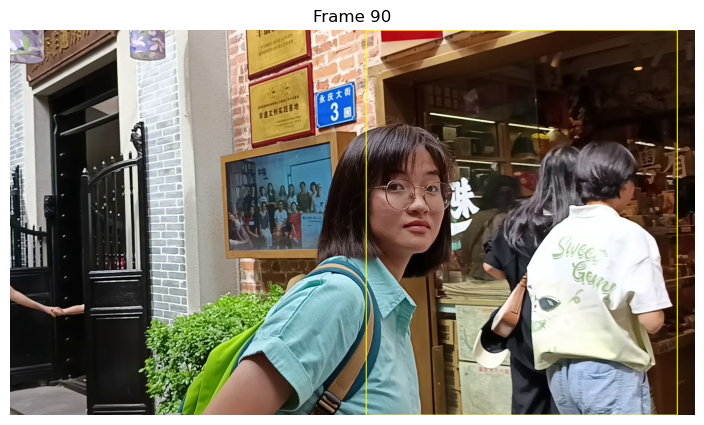

KeyboardInterrupt: 

In [50]:
# GLOBAL SETUPS
TEMPLATE_BANK_SIZE = 5
NCC_THRESHOLD = 0.5
template_bank = []

video_path = "../../videos/ficen.mp4"
template_path = "../../outputs/segmented/ficen_segmented.png"
output_path = "../../outputs/dttm_output.mp4"

dynamic_template_matching(
    video_path=video_path,
    initial_template_path=template_path,
    output_path=output_path,
    threshold=0.3,     # Matching confidences
    nms_thresh=0.3     # NMS IoU threshold
)